# **Self Attention GAN: CelebA**  

**Data**  
> https://www.kaggle.com/jessicali9530/celeba-dataset  

In [1]:
import torch
import torch.nn as nn
import torchvision.utils as utils
import torch.optim as optim 
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.nn.utils import spectral_norm 
from torch.autograd import Variable

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [2]:
workers = 2
batch_size = 64
nz = 100
nc = 3
image_size = 64

epochs = 100
G_lr, D_lr = 0.0001, 0.0004
beta1, beta2 = 0.0, 0.9
lamb = 10
n_critic = 5
isCuda = True

device = torch.device("cuda:0" if (torch.cuda.is_available() and isCuda) else "cpu")
torch.backends.cudnn.benchmark = True

model_saved_dir = "./model"

print("Device: ", end="")
print(device)

Device: cuda:0


In [ ]:
import os.path

if os.path.isfile('~/.kaggle/kaggle.json'):
    print("Already kaggle.json exsits.")
else:
    !mkdir -p ~/.kaggle
    !cp ./kaggle.json ~/.kaggle/ 
    !chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d jessicali9530/celeba-dataset
if os.path.isdir('./img_align_celeba'):
    print("Already unzip.")
else:
    !unzip -q celeba-dataset.zip
    print("Unzip Complete!")

In [3]:
dataset = datasets.ImageFolder(root='./img_align_celeba',
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

In [4]:
# Restore images to suitable images of opencv style
def ImgForPlot(img):
    img = np.einsum('ijk->jki', img)
    img = (127.5*(img+1)).astype(np.uint8)
    return img

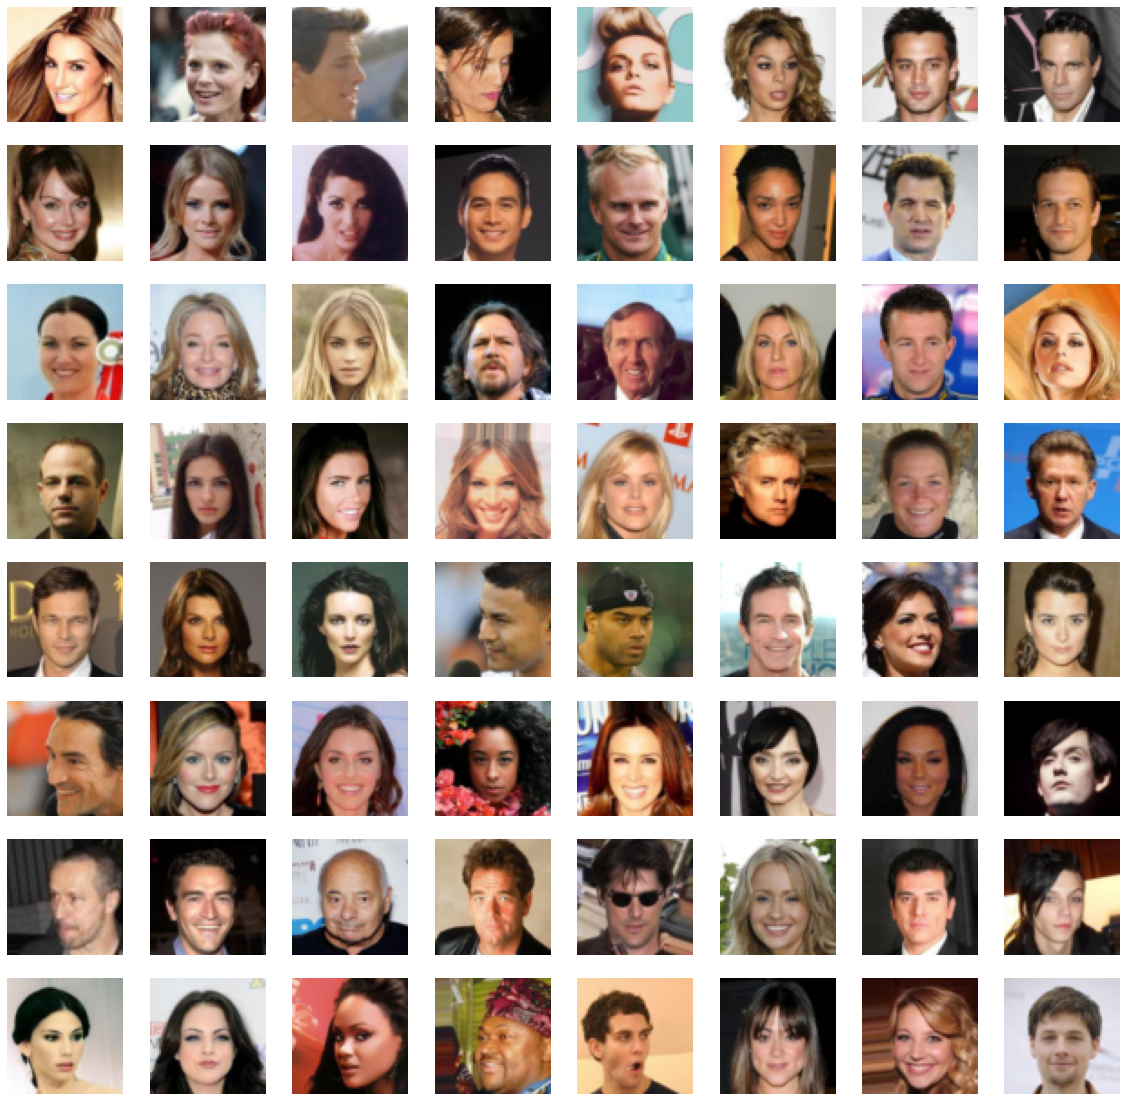

In [5]:
fig = plt.figure(figsize=(20,20))

for k in range(64):
    img, idx = dataset[k]
    ax = fig.add_subplot(8, 8, k+1)
    ax.imshow(ImgForPlot(img))
    ax.axis("off")

plt.show()

## Weight Initialization

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Self Attention

In [6]:
class Self_Attention(nn.Module):
    def __init__(self, in_channels):
        super(Self_Attention, self).__init__()
        self.query_conv = nn.Conv2d(in_channels, in_channels//8, 1)
        self.key_conv = nn.Conv2d(in_channels, in_channels//8, 1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, 1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, x):
        B, C, W, H = x.size()
        query = self.query_conv(x).view(B, -1, W*H).permute(0,2,1)
        key = self.key_conv(x).view(B, -1, W*H)
        attention = self.softmax(torch.bmm(query, key))
        value = self.value_conv(x).view(B, -1, W*H)
        output = torch.bmm(value, attention.permute(0,2,1))
        output = output.view(B, C, W, H)
        output = x + self.gamma * output
        
        return output, attention

## Generator

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.downsample1 = nn.Sequential(
            # 1 x 1 x nz
            spectral_norm(nn.ConvTranspose2d(nz, 512, 4, 1, 0)),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            # 4 x 4 x 512
            spectral_norm(nn.ConvTranspose2d(512, 256, 4, 2, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # 8 x 8 x 256
            spectral_norm(nn.ConvTranspose2d(256, 128, 4, 2, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
            # 16 x 16 x 128    
        )
        self.downsample2 = nn.Sequential(
            # 16 x 16 x 128
            spectral_norm(nn.ConvTranspose2d(128, 64, 4, 2, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
            # 32 x 32 x 64
        )
        self.attention1 = Self_Attention(128)
        self.attention2 = Self_Attention(64)
        self.convT = nn.ConvTranspose2d(64, nc, 4, 2, 1)
        self.tanh = nn.Tanh()
        
        self.attention1.apply(weights_init)
        self.attention2.apply(weights_init)

    def forward(self, x):
        out = self.downsample1(x)
        out, att1 = self.attention1(out)
        out = self.downsample2(out)
        out, att2 = self.attention2(out)
        out = self.tanh(self.convT(out))
        
        return out, att1, att2
    
    def saveAttention(self, path):
        torch.save(self.attention1.state_dict(), path.replace('.pt', '_att1.pt'))
        torch.save(self.attention2.state_dict(), path.replace('.pt', '_att2.pt'))
        
    def loadAttention(self, path):
        self.attention1.load_state_dict(torch.load(path.replace('.pt', '_att1.pt')))
        self.attention2.load_state_dict(torch.load(path.replace('.pt', '_att2.pt')))        

## Discriminator

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.upsample1 = nn.Sequential(
            # 64 x 64 x nc
            spectral_norm(nn.Conv2d(nc, 64, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            # 32 x 32 x 64
            spectral_norm(nn.Conv2d(64, 128, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            # 16 x 16 x 128
            spectral_norm(nn.Conv2d(128, 256, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True)
            # 8 x 8 x 256
        )
        self.upsample2 = nn.Sequential(
            # 8 x 8 x 256
            spectral_norm(nn.Conv2d(256, 512, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True)
            # 4 x 4 x 512
        )
        self.attention1 = Self_Attention(256)
        self.attention2 = Self_Attention(512)
        self.conv = nn.Conv2d(512, 1, 4, 1, 0)
        
        self.attention1.apply(weights_init)
        self.attention2.apply(weights_init)

    def forward(self, x):
        out = self.upsample1(x)
        out, att1 = self.attention1(out)
        out = self.upsample2(out)
        out, att2 = self.attention2(out)
        out = self.conv(out)
        return out, att1, att2
    
    def saveAttention(self, path):
        torch.save(self.attention1.state_dict(), path.replace('.pt', '_att1.pt'))
        torch.save(self.attention2.state_dict(), path.replace('.pt', '_att2.pt'))
        
    def loadAttention(self, path):
        self.attention1.load_state_dict(torch.load(path.replace('.pt', '_att1.pt')))
        self.attention2.load_state_dict(torch.load(path.replace('.pt', '_att2.pt')))        

## Making models

In [9]:
netG = Generator().to(device)
netD = Discriminator().to(device)

In [16]:
netG.apply(weights_init)
netD.apply(weights_init)

Discriminator(
  (upsample1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (upsample2): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (attention1): Self_Attention(
    (query_conv): Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1))
    (key_conv): Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1))
    (value_conv): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (softmax): Softmax(dim=-1)
  )
  (attention2): Self_Attention(
    (query_conv): Conv2d(512, 64, kernel_size=(1, 1), 

## (Option) Load models and lists

In [10]:
model_name = 'SAGAN_CelebA_autosave'

img_list_path = F"{model_saved_dir}/{model_name}_img_list.txt"
losses_path = F"{model_saved_dir}/{model_name}_losses.txt"
noise_path = F"{model_saved_dir}/{model_name}_noise.txt"
G_path = F"{model_saved_dir}/{model_name}_G.pt"
D_path = F"{model_saved_dir}/{model_name}_D.pt"

with open(img_list_path, 'rb') as f:
    img_list = pickle.load(f)
with open(losses_path, 'rb') as f:
    G_losses, D_losses = pickle.load(f)
with open(noise_path, 'rb') as f:
    fixed_noise = pickle.load(f)

netG.load_state_dict(torch.load(G_path))
netD.load_state_dict(torch.load(D_path))
netG.loadAttention(G_path)
netD.loadAttention(D_path)

## Optimizers

In [11]:
optimizerD = optim.Adam(netD.parameters(), lr=D_lr, betas=(beta1,beta2))
optimizerG = optim.Adam(netG.parameters(), lr=G_lr, betas=(beta1,beta2))

## Training

In [ ]:
model_name = 'SAGAN_CelebA_autosave'

img_list_path = F"{model_saved_dir}/{model_name}_img_list.txt"
losses_path = F"{model_saved_dir}/{model_name}_losses.txt"
noise_path = F"{model_saved_dir}/{model_name}_noise.txt"
G_path = F"{model_saved_dir}/{model_name}_G.pt"
D_path = F"{model_saved_dir}/{model_name}_D.pt"

start_epoch = 0
newTrain = True

if start_epoch == 0 and newTrain:
    img_list, G_losses, D_losses = [], [], []
    fixed_noise = torch.randn(64, nz, 1, 1, device=device)
    with open(noise_path, 'wb') as f:
        pickle.dump(fixed_noise, f)
    
netD.train()
netG.train()

for ep in range(start_epoch, epochs):
    for batch_idx, (image, lbl) in enumerate(dataloader, 0):
        step = ep * len(dataloader) + batch_idx + 1

        b_size = image.shape[0]
        image = Variable(image).cuda()

        # 1. Update Discriminator
        output, _, _ = netD(image)
        errD_real = output.view(-1)
        lossD_real = nn.ReLU()(1.0 - errD_real).mean()   # Hinge Loss

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake, _, _ = netG(noise)
        output, _, _ = netD(fake.detach())
        errD_fake = output.view(-1)
        lossD_fake = nn.ReLU()(1.0 + errD_fake).mean()   # Hinge Loss 

        lossD = lossD_real + lossD_fake

        netD.zero_grad()
        lossD.backward()
        optimizerD.step() 

        # 2. Update Generator
        if step % n_critic == 0:        
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake, _, _ = netG(noise)
            output, _, _ = netD(fake)
            errG = output.view(-1)
            lossG = -errG.mean()

            netG.zero_grad()
            netD.zero_grad()
            lossG.backward()
            optimizerG.step()

        if batch_idx % 50 == 49:
            print('[%3d/%3d][%4d/%4d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f' 
                % (ep+1, epochs, batch_idx+1, len(dataloader), lossD.item(), lossG.item(), 
                   errD_real.mean().item(), errD_fake.mean().item(), errG.mean().item()))
            G_losses.append(lossG.item())
            D_losses.append(lossD.item())
  
    with torch.no_grad():
        fake, _, _ = netG(fixed_noise)
        img_list.append(fake.detach().cpu())

    torch.save(netG.state_dict(), G_path)
    torch.save(netD.state_dict(), D_path)
    netG.saveAttention(G_path)
    netD.saveAttention(D_path)

    with open(img_list_path, 'wb') as f:
        pickle.dump(img_list, f)
    with open(losses_path, 'wb') as f:
        pickle.dump((G_losses, D_losses), f)

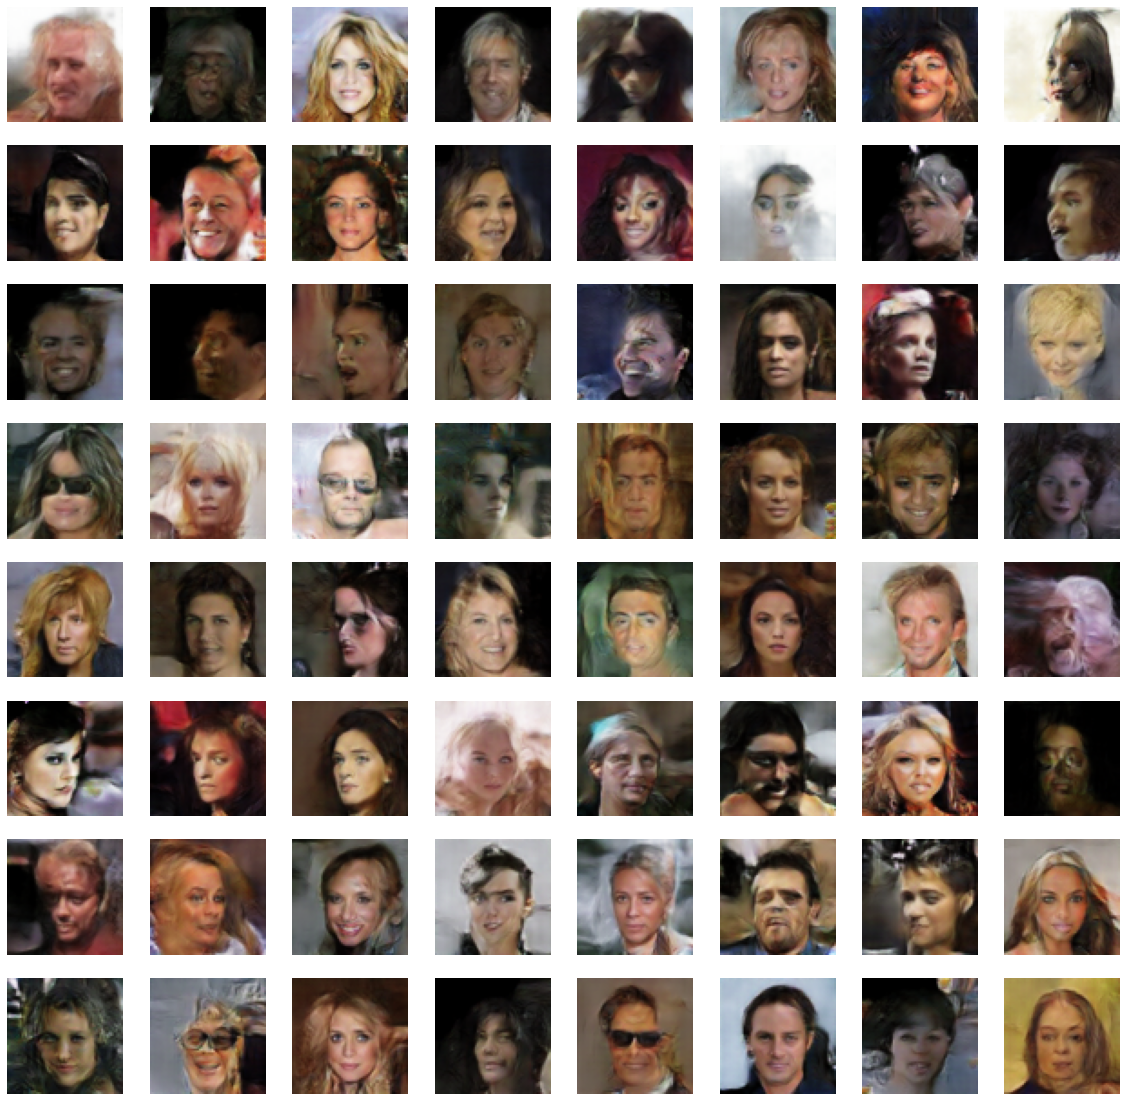

In [12]:
fig = plt.figure(figsize=(20,20))

for k in range(64):
  img = img_list[-1][k]
  ax = fig.add_subplot(8, 8, k+1)
  ax.imshow(ImgForPlot(img))
  ax.axis("off")

plt.show()

### Plot losses of generator and discriminator

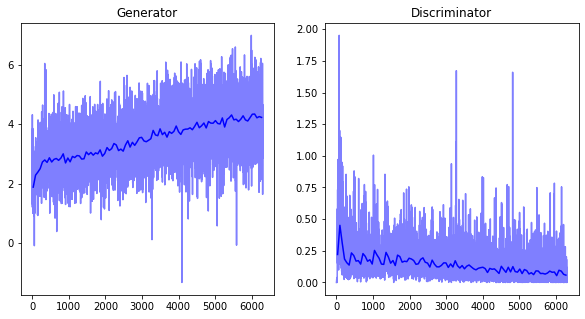

In [13]:
G_losses_ep = []
D_losses_ep = []

cnt = 0
for i in range(epochs):
  G_sum, D_sum = 0.0, 0.0
  for j in range(63):
    G_sum += G_losses[cnt]
    D_sum += D_losses[cnt]
    cnt += 1
  G_losses_ep.append(G_sum/63.0)
  D_losses_ep.append(D_sum/63.0)

fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(1, 2, 1)
ax.plot(range(len(G_losses)), G_losses, c=[0, 0, 1, 0.5])
ax.plot(range(31, len(G_losses)+31, 63), G_losses_ep, c=[0, 0, 1, 1])
ax.set_title("Generator")
ax = fig.add_subplot(1, 2, 2)
ax.plot(range(len(D_losses)), D_losses, c=[0, 0, 1, 0.5])
ax.plot(range(31, len(D_losses)+31, 63), D_losses_ep, c=[0, 0, 1, 1])
ax.set_title("Discriminator")

plt.show()

## Save models and images in drive

In [14]:
model_name = 'SAGAN_CelebA'

img_list_path = F"{model_saved_dir}/{model_name}_img_list.txt"
losses_path = F"{model_saved_dir}/{model_name}_losses.txt"
noise_path = F"{model_saved_dir}/{model_name}_noise.txt"
G_path = F"{model_saved_dir}/{model_name}_G.pt"
D_path = F"{model_saved_dir}/{model_name}_D.pt"

torch.save(netG.state_dict(), G_path)
torch.save(netD.state_dict(), D_path)
netG.saveAttention(G_path)
netD.saveAttention(D_path)

with open(img_list_path, 'wb') as f:
    pickle.dump(img_list, f)
with open(losses_path, 'wb') as f:
    pickle.dump((G_losses, D_losses), f)
with open(noise_path, 'wb') as f:
    pickle.dump(fixed_noise, f)

print(F"Saved {model_name} Completed!")

Saved SAGAN_CelebA Completed!


### How generator improved

In [ ]:
from matplotlib.animation import FuncAnimation
from matplotlib import rcParams
from IPython.display import HTML, clear_output

rcParams['animation.embed_limit'] = 2**128

ims = []
SIZE = 10
fig = plt.figure(figsize=(SIZE, SIZE))

imgs = img_list[0].tolist()
for j in range(64):
    ax = fig.add_subplot(8, 8, j+1)
    im = ax.imshow(ImgForPlot(imgs[j]))
    ax.axis("off")
    ims.append(im)

def init():
    for j in range(64):
        ims[j].set_data([[]])

    return tuple(ims)

def update(frame):
    imgs = img_list[frame].tolist()
  
    for j in range(64):
        img = imgs[j]
        ims[j].set_array(ImgForPlot(img))

    return tuple(ims)

ani = FuncAnimation(fig=fig, init_func=init, func=update, interval=200, blit=True, frames=range(len(img_list)))

plt.show()
clear_output(wait = True)

ani.save('train.gif', writer='pillow', fps=5)

## TEST
### Find latent vector of real images with backprop

In [22]:
class latent_vector(nn.Module):
    def __init__(self):
        super(latent_vector, self).__init__()
        self.z_real = nn.Parameter(torch.randn(1, nz, 1, 1, device=device))
        self.z_real.requires_grad_()

    def forward(self):
        netG.eval()
        return netG(self.z_real)


def find_latent(target_img, iterations = 10000):
    netG.eval()

    lv = latent_vector()
    optimizerZ = optim.Adam(lv.parameters(), lr=0.01)
    criterion = nn.MSELoss()

    for i in range(iterations):
        lv.zero_grad()
        gen_img, _, _ = lv()
        loss = criterion(gen_img.view(target_img.shape), target_img)
        loss.backward()
        optimizerZ.step()

    print('Loss: %.4f' % loss.item())
    return lv.z_real

Loss: 0.0426


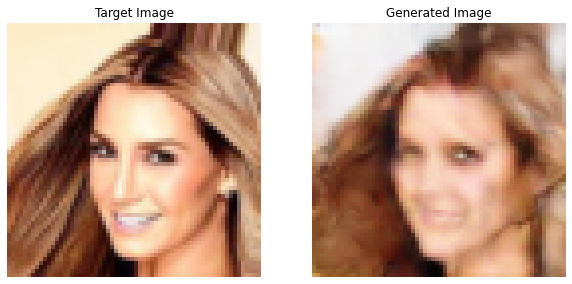

In [23]:
target_image, _ = dataset[0]
target_z = find_latent(target_image.cuda())

netG.eval()
gen_image, _, _ = netG(target_z)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(ImgForPlot(target_image))
ax.set_title('Target Image')
ax.axis("off")
ax = fig.add_subplot(1, 2, 2)
ax.imshow(ImgForPlot(gen_image.squeeze_(0).cpu().detach().numpy()))
ax.set_title('Generated Image')
ax.axis("off")
plt.show()

In [25]:
netD.eval()

img1, _, _ = netD(target_image.view(1,nc,image_size,image_size).cuda())
img2, _, _ = netD(gen_image.view(1,nc,image_size,image_size).cuda())

print('Target Image: %.4f' % img1)
print('Generated Image: %.4f' % img2)

Target Image: 11.1190
Generated Image: -3.6380


### Mapping two images

In [ ]:
idx1, idx2 = 0, 1

target1, _ = dataset[idx1]
target2, _ = dataset[idx2]

z1 = find_latent(target1.cuda())
z2 = find_latent(target2.cuda())

In [ ]:
netG.eval()
imgs = []
for i in range(11):
    alpha = i * 0.1
    z = z1 * (1.0 - alpha) + z2 * alpha
    img = netG(z)
    imgs.append(img.squeeze_(0).cpu().detach().numpy())

fig = plt.figure(figsize=(25, 4))
for i in range(11):
    ax = fig.add_subplot(1, 11, i+1)
    ax.imshow(ImgForPlot(imgs[i]))
    if i == 0:
        ax.set_title('Target Image 1')
    elif i == 10:
        ax.set_title('Target Image 2')
    ax.axis("off")

In [ ]:
netG.eval()
n_imgs = 100
imgs = []
for i in range(n_imgs+1):
    alpha = i * 1.0 / n_imgs
    z = z1 * (1.0 - alpha) + z2 * alpha
    img = netG(z)
    imgs.append(img.squeeze_(0).cpu().detach().numpy())

SIZE = 5
fig = plt.figure(figsize=(SIZE, SIZE))

im = plt.imshow(ImgForPlot(imgs[0]))
plt.axis('off')

def init():
    im.set_data(ImgForPlot(imgs[0]))
    return [im]

def update(frame):
    img = imgs[frame].tolist()
    im.set_array(ImgForPlot(img))

    return [im]

ani = FuncAnimation(fig=fig, init_func=init, func=update, interval=int(5000/n_imgs), blit=True, frames=range(n_imgs+1))

plt.show()
clear_output(wait = True)

ani.save('test-two.gif', writer='pillow', fps=30)

### Making several images

In [ ]:
idxs = [0, 1, 4, 5, 6, 7, 8, 9, 18, 24]

zs = []
for idx in idxs:
    target, _ = dataset[idx]
    zs.append(find_latent(target.cuda()))

In [ ]:
n_imgs_stop = 20
n_imgs_change = 60
SIZE = 5
    
netG.eval()
imgs = []

img = netG(zs[0]).squeeze_(0)
for i in range(n_imgs_stop):
    imgs.append(img.cpu().detach().numpy())

for j in range(len(zs)-1):
    for i in range(n_imgs_change):
        alpha = i * 1.0 / n_imgs_change
        z = zs[j] * (1.0 - alpha) + zs[j+1] * alpha
        img = netG(z).squeeze_(0)
        imgs.append(img.cpu().detach().numpy())
        
    img = netG(zs[j+1]).squeeze_(0)
    for i in range(n_imgs_stop):
        imgs.append(img.cpu().detach().numpy())

for i in range(n_imgs_change):
    alpha = i * 1.0 / n_imgs_change
    z = zs[-1] * (1.0 - alpha) + zs[0] * alpha
    img = netG(z).squeeze_(0)
    imgs.append(img.cpu().detach().numpy())

fig = plt.figure(figsize=(SIZE, SIZE))

im = plt.imshow(ImgForPlot(imgs[0]))
plt.axis('off')

def init():
    im.set_data(ImgForPlot(imgs[0]))
    return [im]

def update(frame):
    img = imgs[frame].tolist()
    im.set_array(ImgForPlot(img))

    return [im]

ani = FuncAnimation(fig=fig, init_func=init, func=update, interval=int(5000/len(imgs)), blit=True, frames=range(len(imgs)))

plt.show()
clear_output(wait = True)

ani.save('test-several.gif', writer='pillow', fps=30)

## Check Attention